# Data Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

As the task description states, we should use ratings (list of favorite films) and users data to make recommendations. So let us load and explore them.

## Loading the dataset

In [2]:
from src.config import DATA_PATH, DATASET_PATH

In [3]:
ratings_df = pd.read_csv(
    DATASET_PATH / "u.data",
    sep="\t",
    header=None,
    names=["user_id", "item_id", "rating", "timestamp"],
)

In [18]:
ratings_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [19]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [4]:
users_df = pd.read_csv(
    DATASET_PATH / "u.user",
    sep="|",
    header=None,
    names=["user_id", "age", "gender", "occupation", "zip_code"],
)

In [21]:
users_df.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [23]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   gender      943 non-null    object
 3   occupation  943 non-null    object
 4   zip_code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB


## Exploring user features

### Gender

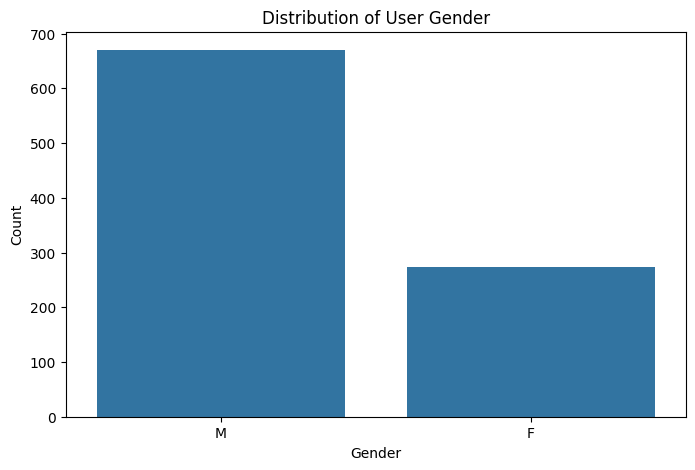

In [33]:
plt.figure(figsize=(8, 5))
sns.countplot(x="gender", data=users_df)
plt.title("Distribution of User Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

This is binary categorical feature that would require preprocess (probably just replacing with 0 and 1) later. As we can see on plot above, most of the users are male.

### Age

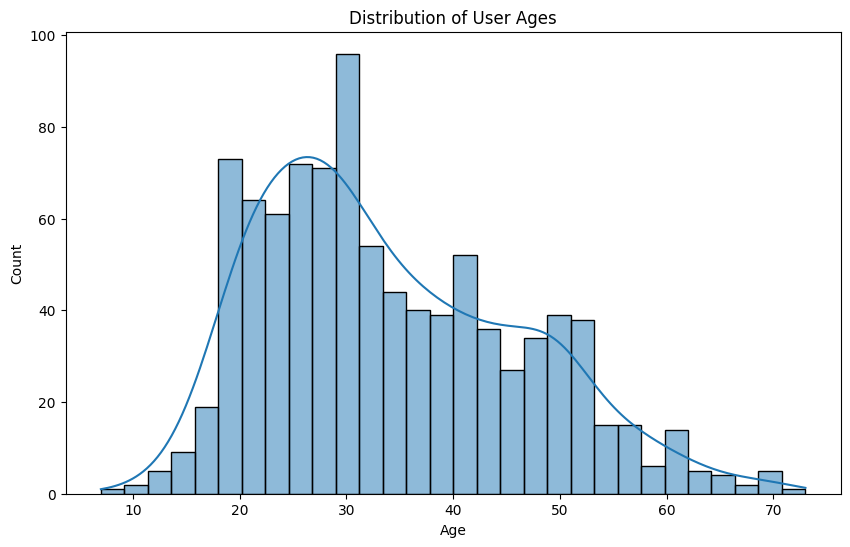

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(users_df.age, bins=30, kde=True)
plt.title("Distribution of User Ages")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

This feature will probably require scaling later (depends on model). As we can see on plot above, most of the users are quite young (between 20 and 40 years old). Let us try to combine it with gender:

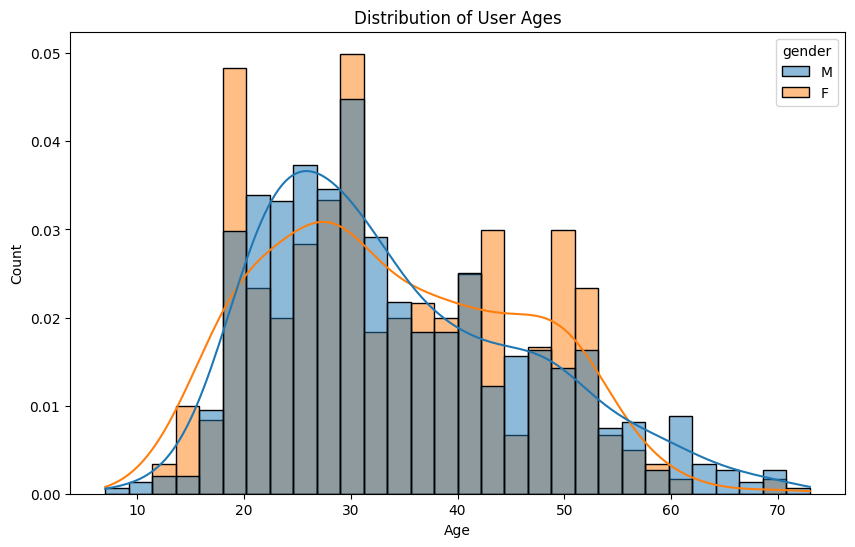

In [45]:
plt.figure(figsize=(10, 6))
sns.histplot(
    users_df,
    bins=30,
    hue="gender",
    x="age",
    stat="density",  # From this plot I am going to use stat="density" and set common_norm=False
    common_norm=False,  # to normalize counts and get rid of imbalance between group sizes
    kde=True,
)
plt.title("Distribution of User Ages")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

As we can see on plot above, age distributions is a bit different, for example, females in age range between 40 and 50 are more frequent than males.

### Occupation

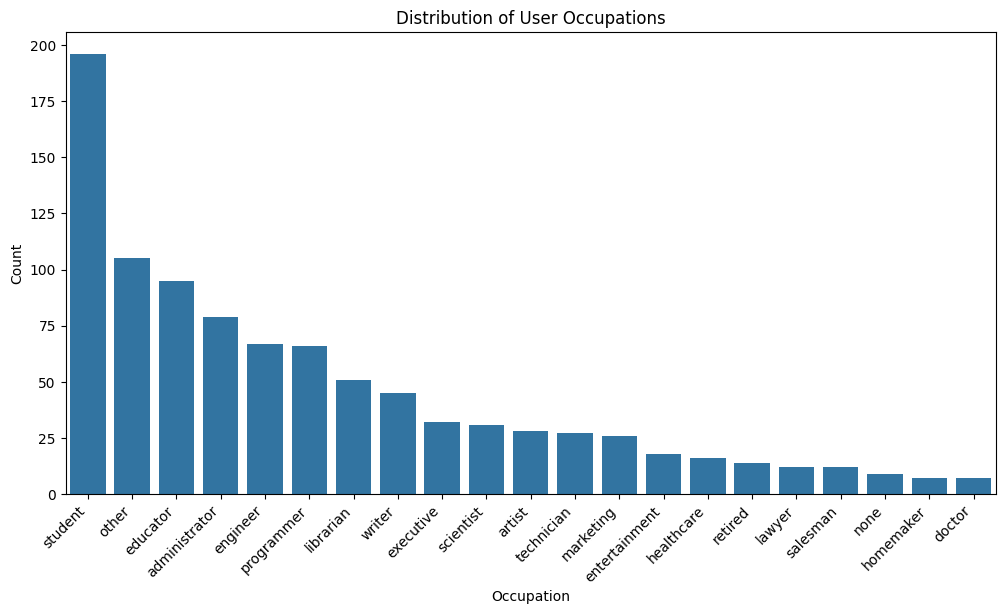

In [47]:
plt.figure(figsize=(12, 6))
sns.countplot(
    x="occupation", data=users_df, order=users_df["occupation"].value_counts().index
)
plt.title("Distribution of User Occupations")
plt.xlabel("Occupation")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

This categorical feature would require preprocessing (probably with one-hot encoding) later. As we can see on plot above, most of the users are from "student" occupation, which matches with the age distribution considered earlier. 

Let us plot this features against previously considered age and gender:

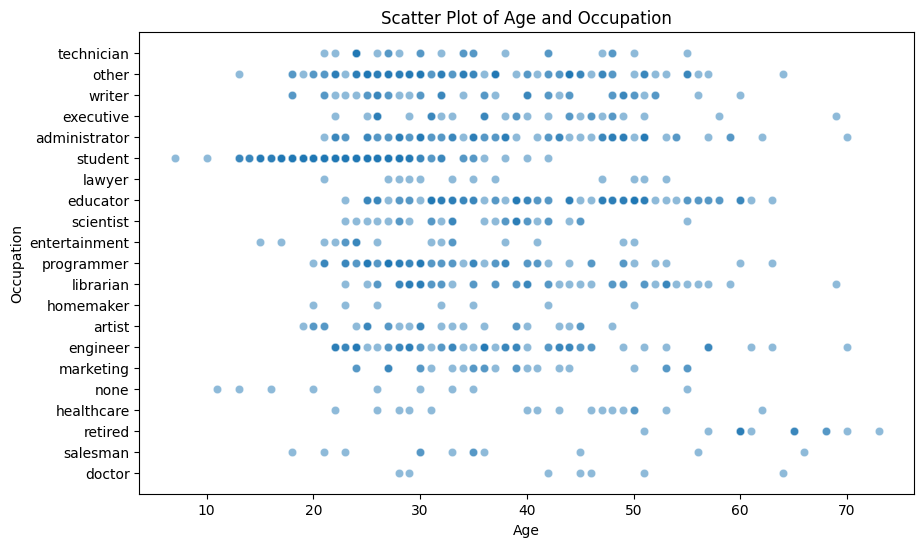

In [51]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x="age", y="occupation", data=users_df, alpha=0.5)
plt.title("Scatter Plot of Age and Occupation")
plt.xlabel("Age")
plt.ylabel("Occupation")
plt.show()

We can see on the plot above some correlations between age and occupation. For example, student or retired persons have narrow age range, while other occupations are have broader age range.

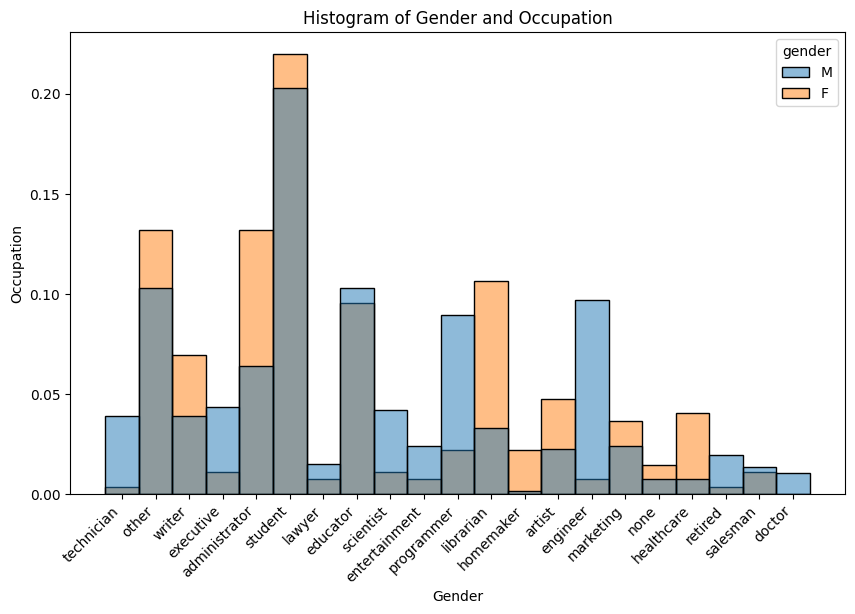

In [58]:
plt.figure(figsize=(10, 6))
plt.title("Histogram of Gender and Occupation")
sns.histplot(
    x="occupation", data=users_df, hue="gender", stat="density", common_norm=False
)
plt.xlabel("Gender")
plt.ylabel("Occupation")
plt.xticks(rotation=45, ha="right")

plt.show()

We can see on the plot above some correlations between gender and occupation. For example, technicians and engineers are more frequent among males than females.

### Zip codes

In [60]:
zip_codes_freqs = users_df.zip_code.value_counts()

In [63]:
zip_codes_freqs.head()

zip_code
55414    9
55105    6
55337    5
10003    5
20009    5
Name: count, dtype: int64

In [64]:
len(zip_codes_freqs)

795

There are a lot of unique zip codes in dataset, so we can't just one-hot encode them. But we can extract geographical information from them and use it as features.

In [31]:
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
from uszipcode import SearchEngine

In [32]:
search = SearchEngine()

In [33]:
def get_coordinates(zipcode):
    result = search.by_zipcode(zipcode)
    if result:
        coords = result.lat, result.lng
        if coords != (0, 0):
            return coords
    return None, None

In [34]:
coords = users_df["zip_code"].map(get_coordinates).apply(pd.Series)
coords.columns = ["latitude", "longitude"]

In [35]:
coords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   906 non-null    float64
 1   longitude  906 non-null    float64
dtypes: float64(2)
memory usage: 14.9 KB


In [36]:
coords.head()

,latitude,longitude
0,32.21,-110.88
1,37.41,-122.05
2,30.16,-81.70
3,41.57,-83.65
4,40.44,-79.96


In [37]:
users_df = pd.concat([users_df, coords], axis=1)

In [38]:
users_df.head()

,user_id,age,gender,occupation,zip_code,latitude,longitude
0,1,24,M,technician,85711,32.21,-110.88
1,2,53,F,other,94043,37.41,-122.05
2,3,23,M,writer,32067,30.16,-81.70
3,4,24,M,technician,43537,41.57,-83.65
4,5,33,F,other,15213,40.44,-79.96


In [39]:
geometry = [Point(xy) for xy in zip(coords["longitude"], coords["latitude"])]
users_geo_df = gpd.GeoDataFrame(users_df, geometry=geometry)

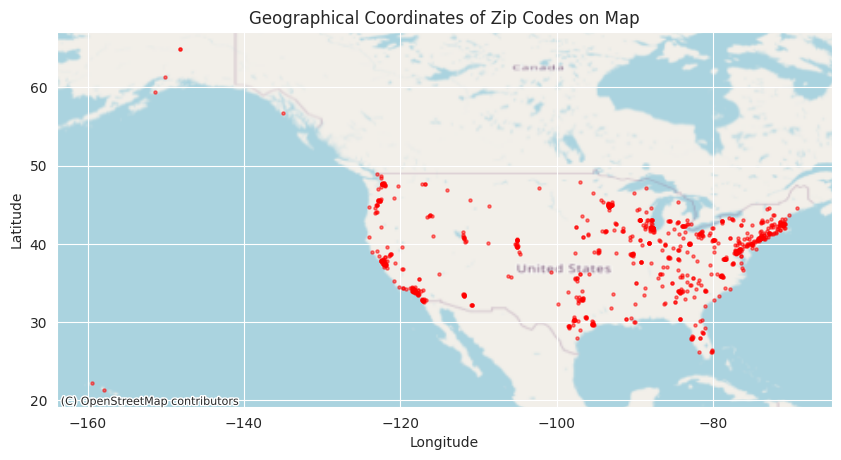

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
users_geo_df[~users_geo_df.latitude.isna()].plot(
    ax=ax, marker="o", color="red", markersize=5, alpha=0.5
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs="epsg:4326")

plt.title("Geographical Coordinates of Zip Codes on Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

As we can see on the map above, most of the users located in conterminous part of the United States and only few of them located in Alaska and Hawaii.

Let us save the dataframe with coordinates:

In [41]:
users_df.to_csv(DATA_PATH / "interim" / "users_with_coordinates.csv", index=False)

## Exploring ratings


### Rating distribution

In [26]:
ratings_counts = ratings_df.rating.value_counts()

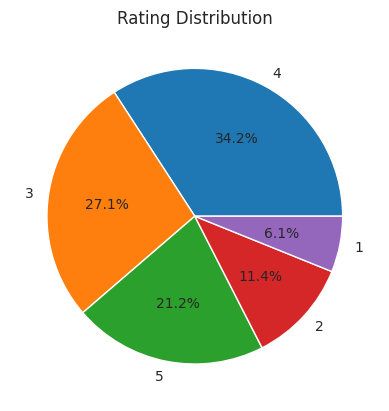

In [27]:
plt.pie(ratings_counts, labels=ratings_counts.index, autopct="%1.1f%%")
plt.title("Rating Distribution")
plt.show()

As we can see on the plot above, roughly a half of ratings are 4 and 5. 

Let us try to plot rating distribution against user features:

### Rating distribution against gender

In [42]:
merged_df = pd.merge(ratings_df, users_df, on="user_id")

In [43]:
merged_df.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code,latitude,longitude
0,196,242,3,881250949,49,M,writer,55105,44.94,-93.17
1,196,393,4,881251863,49,M,writer,55105,44.94,-93.17
2,196,381,4,881251728,49,M,writer,55105,44.94,-93.17
3,196,251,3,881251274,49,M,writer,55105,44.94,-93.17
4,196,655,5,881251793,49,M,writer,55105,44.94,-93.17


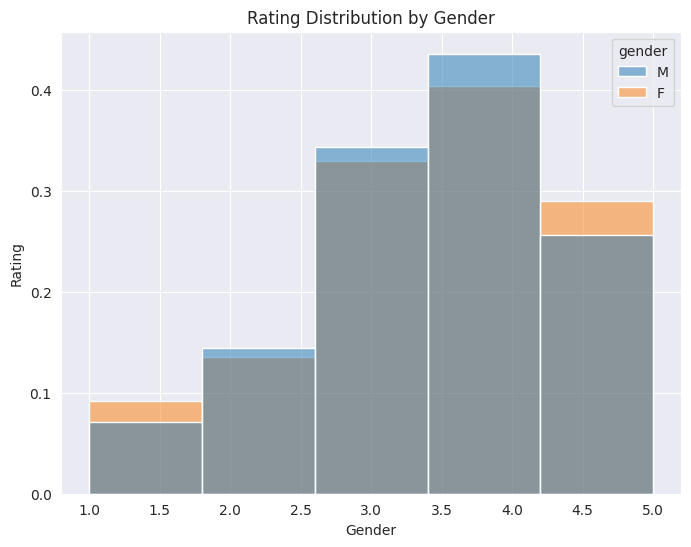

In [50]:
plt.figure(figsize=(8, 6))
sns.histplot(
    x="rating", hue="gender", data=merged_df, stat="density", common_norm=False, bins=5
)
plt.title("Rating Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Rating")
plt.show()

Rating distribution against gender looks quite the same, but we can see that females tend to give more 1 and 5-star reviews than males.

### Rating distribution against age

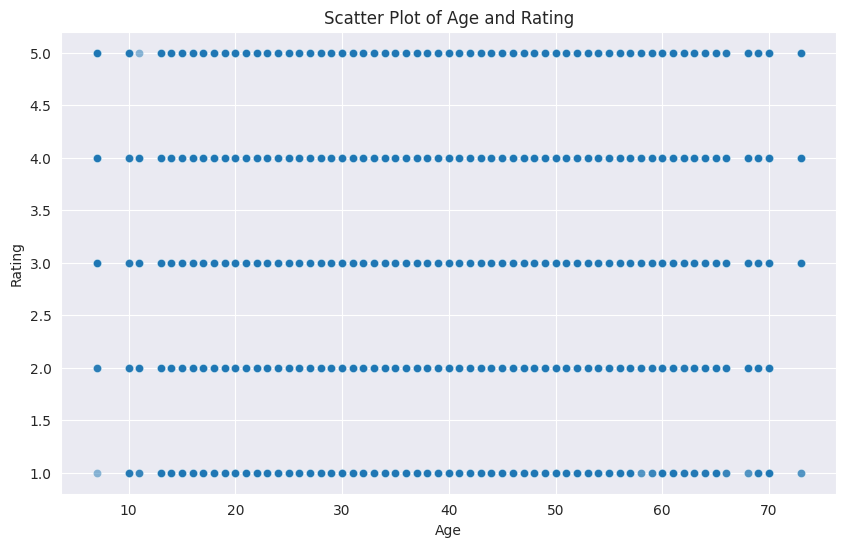

In [52]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x="age", y="rating", data=merged_df, alpha=0.5)
plt.title("Scatter Plot of Age and Rating")
plt.xlabel("Age")
plt.ylabel("Rating")
plt.show()

As we can see on plot above, there is no correlation between age and rating.

### Rating distribution against occupation

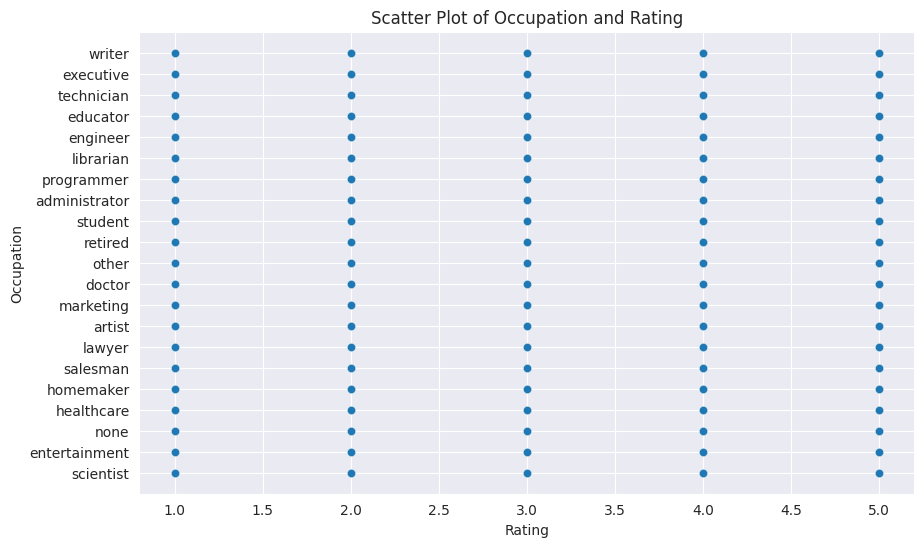

In [55]:
plt.figure(figsize=(10, 6))

sns.scatterplot(y="occupation", x="rating", data=merged_df, alpha=0.5)
plt.title("Scatter Plot of Occupation and Rating")
plt.ylabel("Occupation")
plt.xlabel("Rating")
plt.show()

The same situation as before: no correlation.